In [149]:
from PYME.IO.image import ImageStack
from double_helix.DoubleGaussFit import Detector
import matplotlib.pyplot as plt
from scipy import ndimage
import numpy as np
import os
from PYME.recipes.processing import BackgroundSubtractionMovingPercentile
from PYME.localization.remFitBuf import fitTask
# %matplotlib widget
plt.set_loglevel("warning")

In [10]:
image_stack_647 = ImageStack(filename = "E:/Toxoplasma_Fixed_Cell_Imaging/20241219_MyoH_ALFA_Gels/P2S6/FOV9_647.h5", haveGUI=False)
image_stack_647.mdh['Camera.NoiseFactor'] = 1.4 # typical for EMCCD with gain > 10
image_stack_647.mdh['Camera.ElectronsPerCount'] = 12.9  # e-/ADU
image_stack_647.mdh['Camera.TrueEMGain'] = 272
image_stack_647.mdh['Camera.ADOffset'] = 110 # [ADU]
image_stack_647.mdh['voxelsize.x'] = 0.1174 # [um]
image_stack_647.mdh['voxelsize.y'] = 0.1174 # [um]
image_stack_647.mdh['Camera.ReadNoise']

filename == E:\Toxoplasma_Fixed_Cell_Imaging\20241219_MyoH_ALFA_Gels\P2S6\FOV9_647.h5
E:\Toxoplasma_Fixed_Cell_Imaging\20241219_MyoH_ALFA_Gels\analysis\P2S6\FOV9_647.h5r


52.2

In [51]:
bg_sub_647 = BackgroundSubtractionMovingPercentile().apply_simple(image_stack_647)

c:\userfiles\code\dh_pyme_dev\PYME\recipes\processing.py:2500: PYMEDeprecationWarning: This will either disappear or change function as we move to a 5D data model. Use the explicit .data_xytc instead, or even better, change to using the 5D model as image.data_xyztc or image.voxels
  bgs = BGSDataSource.DataSource(input_name.data, bgRange=self.window)
c:\userfiles\code\dh_pyme_dev\PYME\IO\MetaDataHandler.py:666: UserWarning: DictMDHandler is not yet fully supported, and will likely cause failures for anything related to localisation fitting
  warnings.warn('DictMDHandler is not yet fully supported, and will likely cause failures for anything related to localisation fitting')


In [178]:
frame_nums = np.asarray([1125, 1126, 1129, 6263, 6305, 6314, 11544, 11547, 16076, 16077, 16038, 16085, 17211, 19473, 25381])

test_frames_647 = np.empty([260,260,15])
test_frames_sigma_647 = np.empty([260,260,15])
test_frames_bg_subbed_647 = np.empty([260,260,15])

for i in range(np.size(frame_nums)):

    test_frames_647[:,:,i] = np.squeeze(image_stack_647.data_xytc[240:500,240:500, frame_nums[i],:])
    test_frames_bg_subbed_647[:,:,i] = np.squeeze(bg_sub_647.data_xytc[240:500,240:500, frame_nums[i],:])
    test_frames_sigma_647[:,:,i] = np.squeeze(fitTask.calcSigma(image_stack_647.mdh, test_frames_647[:,:,i].astype('f')))


8
16
8
16
8
16
8
16
8
16
8
16
8
16
8
16
8
16
8
16
8
16
8
16
8
16
8
16
8
16


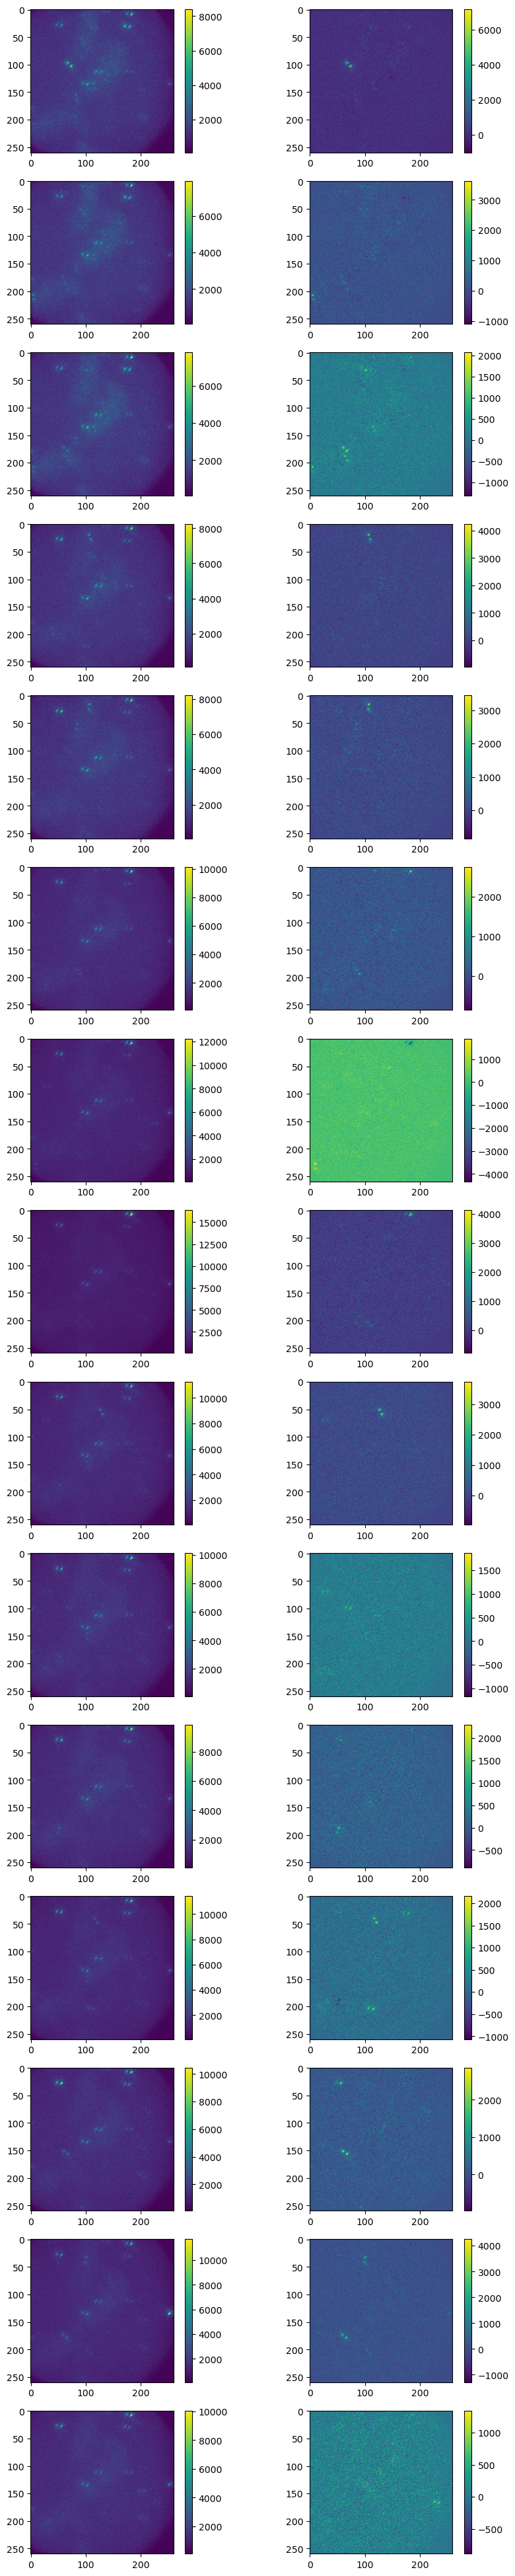

In [179]:
fig, axs = plt.subplots(15, 2, figsize=(10, 50))

for i in list(range(15)):
    im1 = axs[i, 0].imshow(test_frames_647[:,:,i])
    plt.colorbar(im1, ax=axs[i,0])
    im2 = axs[i, 1].imshow(test_frames_bg_subbed_647[:,:,i])
    plt.colorbar(im2, ax=axs[i,1])
    

In [184]:
detector_647 = Detector(roi_half_size=10, l_initial=1025, lobe_sigma_initial=197, filter_sigma=4, px_size_nm=117.4)

Optimization terminated successfully.
         Current function value: -0.012173
         Iterations: 15
         Function evaluations: 30


In [185]:
strength_images_647 = np.empty([260,260,15])
angle_images_647 = np.empty([260,260,15])

for i in range(np.size(frame_nums)):

    strength_images_647[:,:,i], angle_images_647[:,:,i] = detector_647.filter_frame(test_frames_bg_subbed_647[:,:,i])

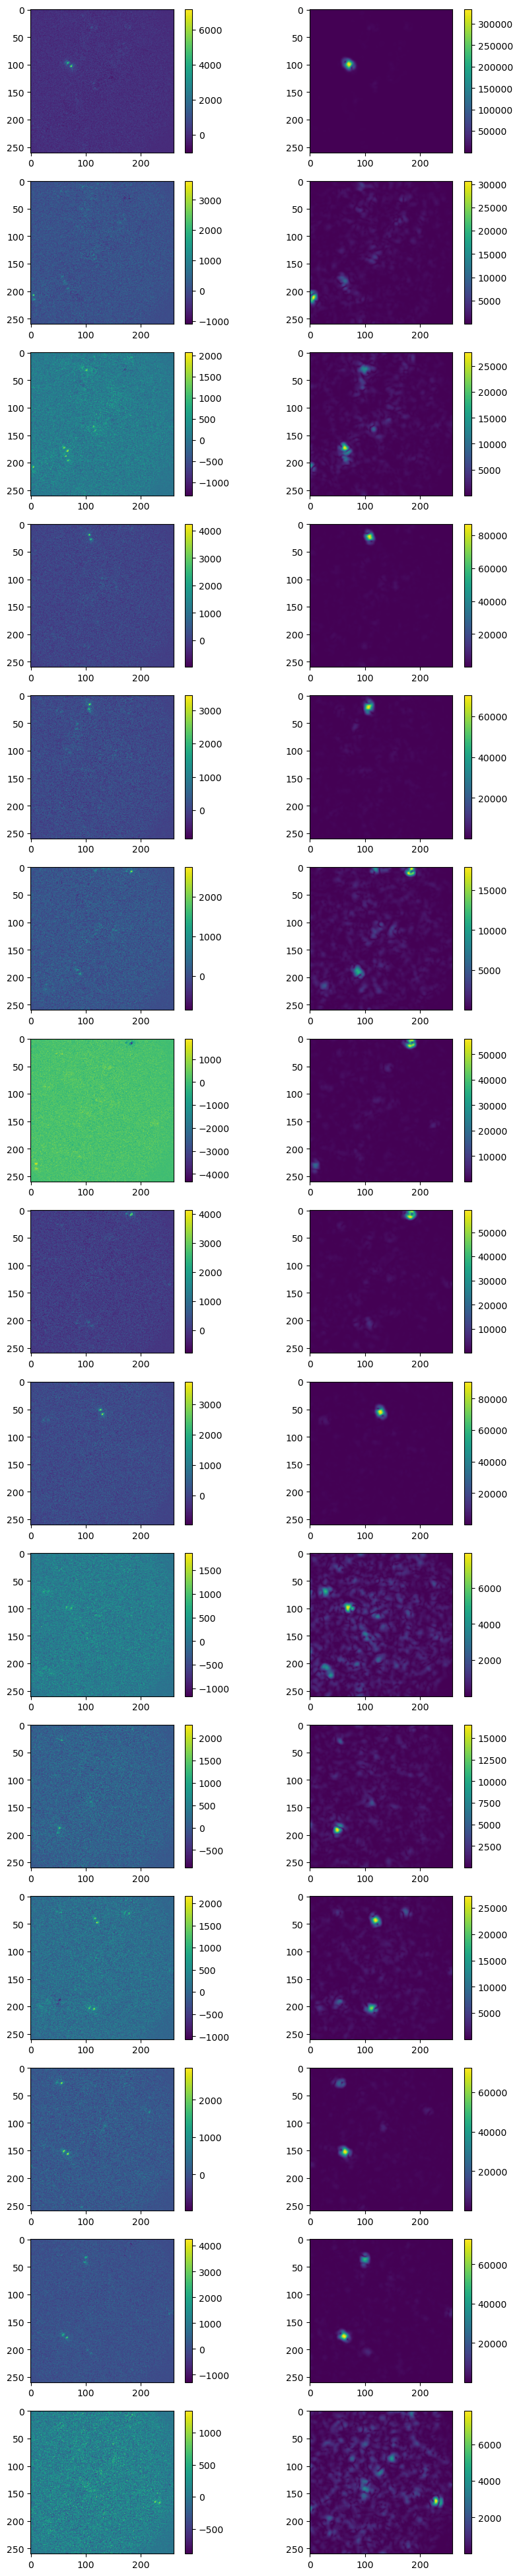

In [186]:
fig, axs = plt.subplots(15, 2, figsize=(10, 50))

for i in list(range(15)):
    im1 = axs[i, 0].imshow(test_frames_bg_subbed_647[:,:,i])
    plt.colorbar(im1, ax=axs[i,0])
    im2 = axs[i, 1].imshow(strength_images_647[:,:,i])
    plt.colorbar(im2, ax=axs[i,1])

In [162]:
def lobe_estimate_from_center_pixel(x_pix, y_pix, orientation, lobe_sep_px):
    dx = np.cos(orientation) * lobe_sep_px
    dy = np.sin(orientation) * lobe_sep_px
    x1 = x_pix - dx
    y1 = y_pix - dy
    x2 = x_pix + dx
    y2 = y_pix + dy
    return x1, y1, x2, y2

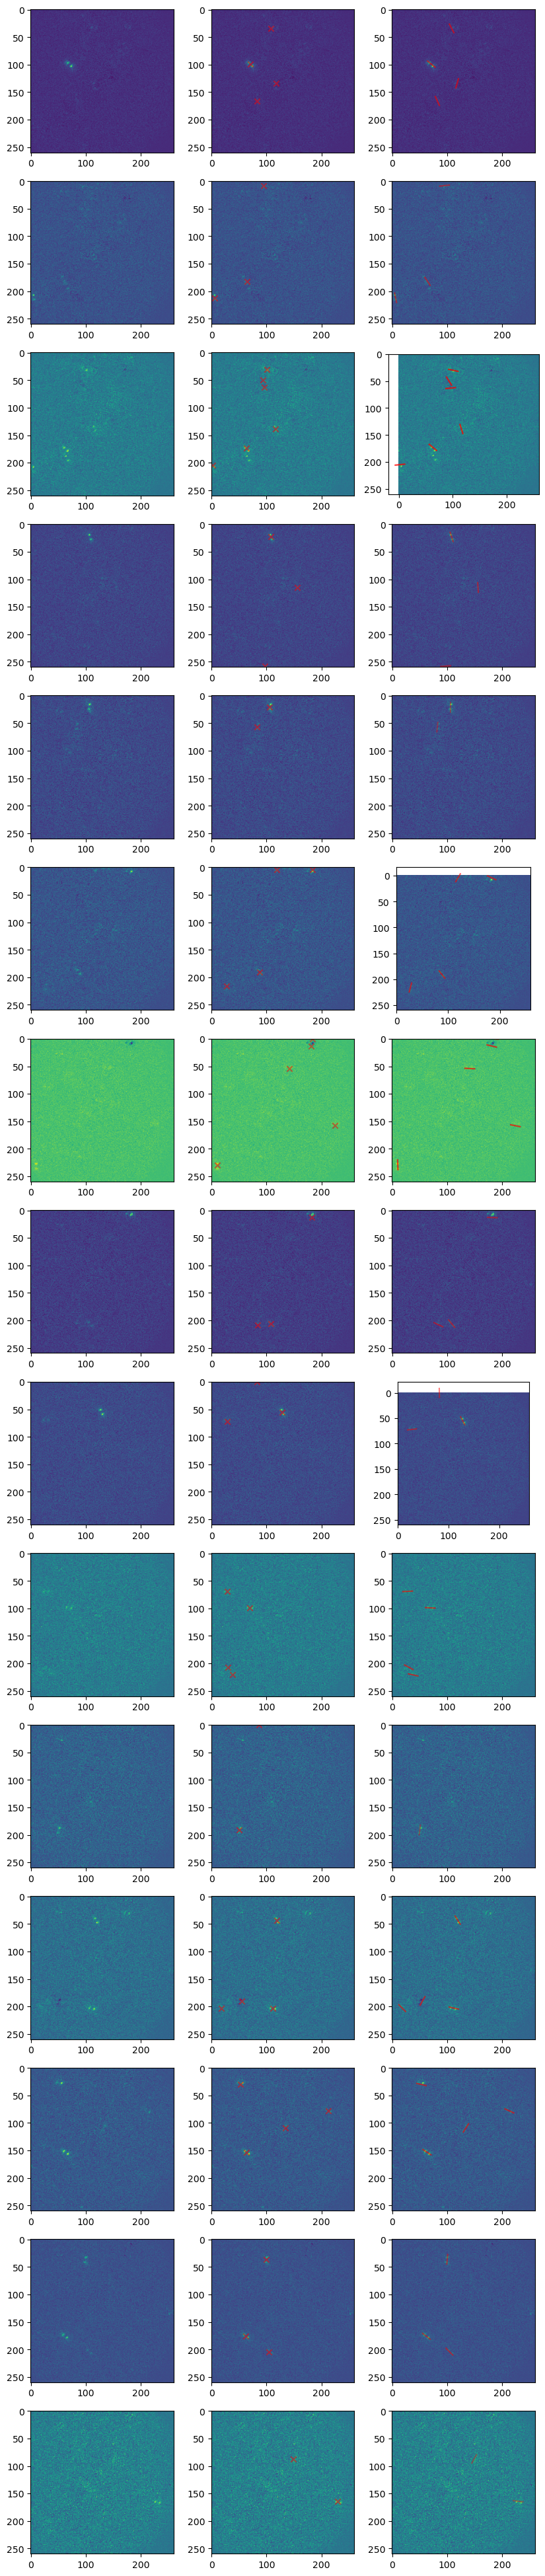

In [191]:
thresh = 1.7

fig, axs = plt.subplots(15, 3, figsize=(10, 50))
for i in range(np.size(frame_nums)):

    row, col, orientation = detector_647.extract_candidates(strength_images_647[:,:,i], angle_images_647[:,:,i], (thresh * test_frames_sigma_647[:,:,i])**2 * detector_647.normFactor)
    
    x1, y1, x2, y2 = lobe_estimate_from_center_pixel(col, row, orientation, 1025/117.4)
    
    axs[i, 0].imshow(test_frames_bg_subbed_647[:,:,i])
    axs[i, 1].imshow(test_frames_bg_subbed_647[:,:,i])
    axs[i, 1].scatter(col, row, marker='x', c='red', alpha=0.5)
    axs[i, 2].imshow(test_frames_bg_subbed_647[:,:,i])
    for ii in range(len(row)):
        axs[i, 2].plot([x1, x2], [y1, y2], 'r', alpha=0.2)
    